In [1]:
import importlib.util
import sys
import pickle
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

In [2]:
!pip install proportion-localised
import proportion_localised as pl


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\alext\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
import os
import inspect
current_path = os.path.abspath(inspect.getfile(inspect.currentframe()))
current_dir = os.path.dirname(current_path)
with open(os.path.join("..", "demo_data", "pl_demo_data.pk"), "rb") as f:
    input_images, predictions, ground_truths = pickle.load(f)

#### See some demos of the input images, heatmap predictions, and ground truths

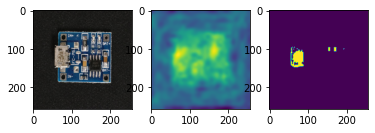

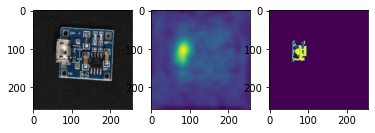

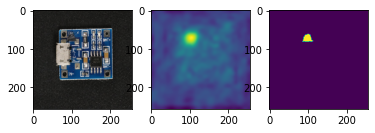

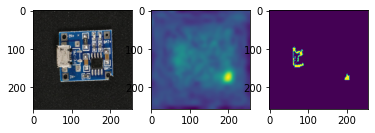

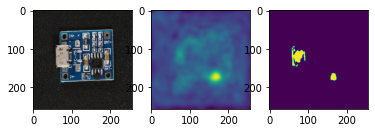

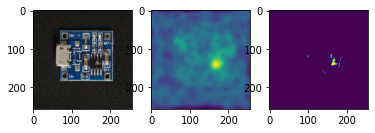

In [4]:
for input_image, prediction, mask in zip(input_images[:6], predictions, ground_truths):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(transforms.ToPILImage()(input_image))
    ax[1].imshow(prediction)
    ax[2].imshow(mask)

In [5]:
file_path = r"../proportion-localised/__main__.py"

Predictions shape:  torch.Size([10, 256, 256])
Ground truths shape:  torch.Size([10, 256, 256])


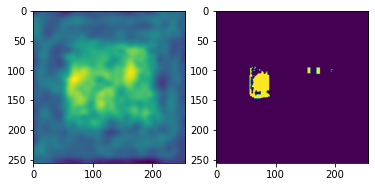

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(predictions[0])
axes[1].imshow(ground_truths[0])
print("Predictions shape: ", predictions.shape)
print("Ground truths shape: ", ground_truths.shape)

### The default is to return the score and the data

In [7]:
# one off quick calculation
score, data = pl.calculate(predictions, ground_truths, iou_limit=0.3)

In [8]:
score

0.65

### You can just receive the score for simplicity

In [9]:
# one off quick calculation
score = pl.calculate(predictions, ground_truths, iou_limit=0.3, return_score_only=True)
score

0.65

### Try different IoU limits

In [10]:
score, data = pl.calculate(predictions, ground_truths, iou_limit=0.5)
score

0.4

### If you know that in the predictions, lower represent lower probability of anomaly, you can enable anomaly_likelihood_definitely_increasing for faster calculation

In [11]:
score, data = pl.calculate(predictions, ground_truths, iou_limit=0.3, anomaly_likelihood_definitely_increasing=True)
score

0.65

If the predictions are the wrong way round, and anomaly_likelihood_definitely_increasing is set to true, the calculation will go wrong

In [12]:
score, data = pl.calculate(predictions*-1, ground_truths, iou_limit=0.3, anomaly_likelihood_definitely_increasing=True)
score

0.0

However, it will always work if anomaly_likelihood_definitely_increasing is set to false (the default)

In [13]:
score, data = pl.calculate(predictions*-1, ground_truths, iou_limit=0.3, anomaly_likelihood_definitely_increasing=False)
score

0.65

#### You can get an instance of the PL class
This allows to you trial multiple IoU limits, without re-running the main bulk of the calculation (as the iou array is cached)

In [14]:
# importing the object allows quick calculations of different iou limits, due to the cached data 
import time
pl_object = pl.get_PL_instance()
for iou_limit in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    start = time.time()
    print(f"iou_limit: {iou_limit} - PL: {pl_object.calculate(predictions, ground_truths, iou_limit=iou_limit)[0]} time taken: {time.time() - start:.3g}s")

iou_limit: 0.1 - PL: 0.9 time taken: 0.915s
iou_limit: 0.2 - PL: 0.7 time taken: 0s
iou_limit: 0.3 - PL: 0.65 time taken: 0s
iou_limit: 0.4 - PL: 0.55 time taken: 0s
iou_limit: 0.5 - PL: 0.4 time taken: 0s
iou_limit: 0.6 - PL: 0.35 time taken: 0s
iou_limit: 0.7 - PL: 0.2 time taken: 0s
iou_limit: 0.8 - PL: 0.0 time taken: 0s
iou_limit: 0.9 - PL: 0.0 time taken: 0s


#### Lets explore the data given by the calculation

In [15]:
# one off quick calculation
score, data = pl.calculate(predictions, ground_truths, iou_limit=0.3)

In [16]:
iou_array, thres_value, thres_ind, ((all_prediction_masks, all_anomaly_masks, all_bounding_box_infos)) = data

##### The data returns four items:

1. The 2d, array of IoU scores, with the first axis representing threshold and the second axis representing anomaly  

In [17]:
print(iou_array.shape)

# converting the array to binary for whether the IoU limit is reached, 
# then taking the mean across the anomaly axis, 
# then finding the max, gives the PL score 
iou_limit = 0.3
(iou_array>iou_limit).mean(axis=1).max()

(25, 20)


0.65

2. The thres_value is the threshold value which results in the most anomalies satisfying the IoU limit 

In [18]:
print("thres_value: ", thres_value)
score, data = pl.calculate(predictions>thres_value, ground_truths, iou_limit=0.3)
print("PL score: ", score)

thres_value:  2.0312004456153283
PL score:  0.65


3. The thres_ind is the indice this best threshold value is found at 

In [19]:
# when we slice the iou array taking only the row for this thres_ind,
# we get the PL score
(iou_array[thres_ind, :]>iou_limit).mean()

0.65

4. The most interesting of the data, this gives the masked binary predictions, the anomaly-wise ground truths, and the rotated, scaled, and merged bounding box parameters

    -The masking refers to the process of ignoring the parts of the prediction which are closer to another anomaly from the same ground truth. 
    
    -The anomaly wise ground truths are the ground truths for each individual anomaly, for which there may be many.
    
    -The bounding box parameters are: ((center_x, center_y), (width, height), angle_of_rotation)

These are given in a list of lists format, where each outer list corresponds to one input image, ground truth pair, and the inner lists correspond to the masked predictions, and anomaly-wise ground truth for each individual anomaly in the input image and ground truth pair.



### Visualisation

We can use the data above to visualise the process

#### The visualise_PL function allows you to visualise a set of images
Specific indices allows you to only show specific indices (which correspond to the IoUs)

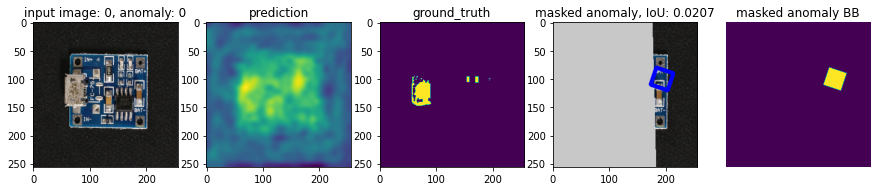

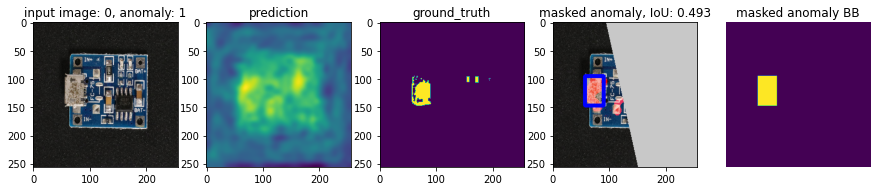

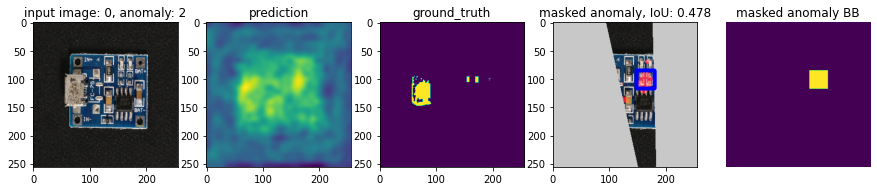

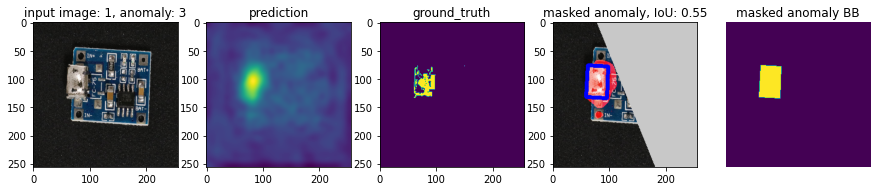

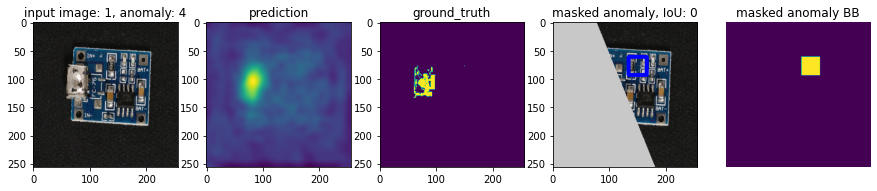

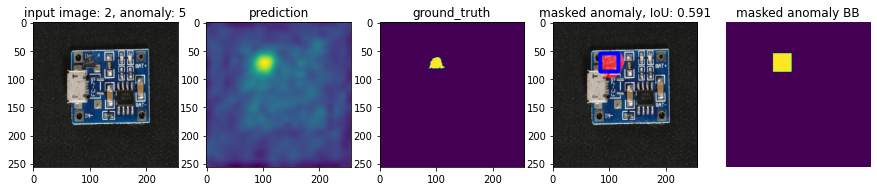

In [20]:
pl.visualise_PL(input_images,
                  predictions,
                  ground_truths, 
                  iou_array,
                  thres_value, 
                  thres_ind,
                  all_prediction_masks, 
                  all_anomaly_masks, 
                  all_bounding_box_infos,
                  specific_indices=[0, 1, 2, 3, 4, 5])

Visualising the IoUs<0.01 (worst IoUs)

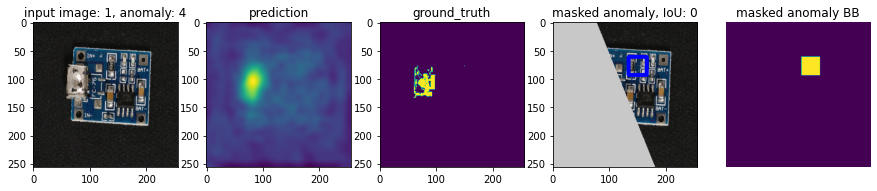

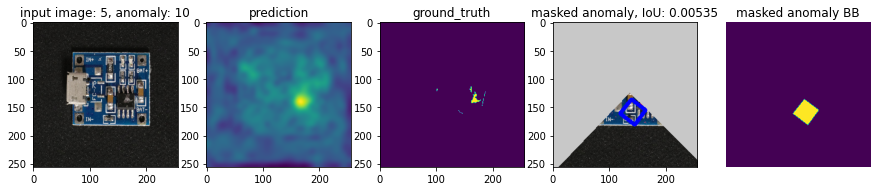

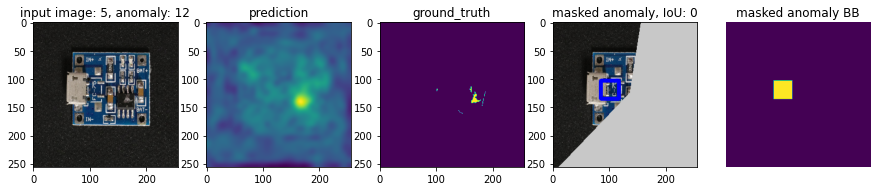

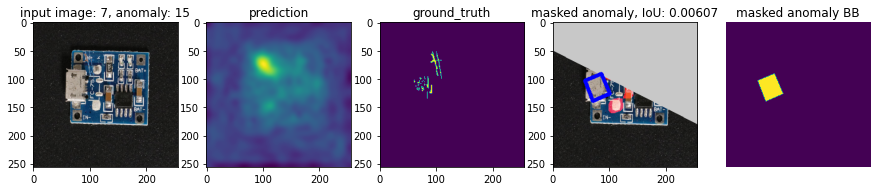

In [21]:
pl.visualise_PL(input_images,
                predictions,
                ground_truths, 
                iou_array,
                thres_value, 
                thres_ind,
                all_prediction_masks, 
                all_anomaly_masks, 
                all_bounding_box_infos,
                specific_indices=np.where(iou_array[thres_ind]<0.01)[0])

Visualising the best IoU

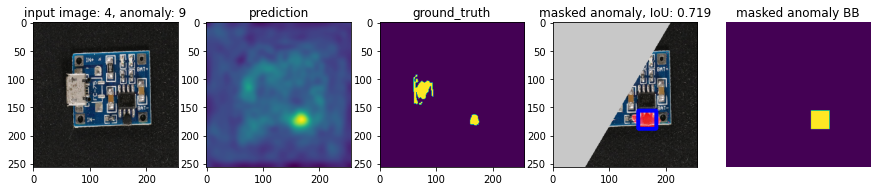

In [22]:
pl.visualise_PL(input_images,
                predictions,
                ground_truths, 
                iou_array,
                thres_value, 
                thres_ind,
                all_prediction_masks, 
                all_anomaly_masks, 
                all_bounding_box_infos,
                specific_indices=np.where(iou_array[thres_ind]==iou_array[thres_ind].max())[0])

Visualising the IoUs>0.75

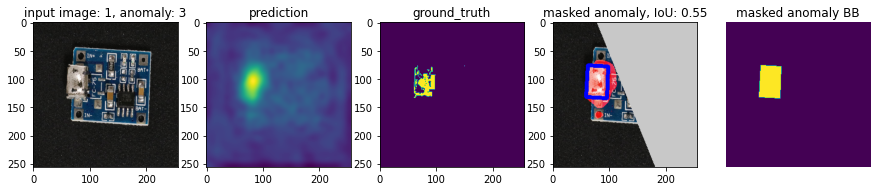

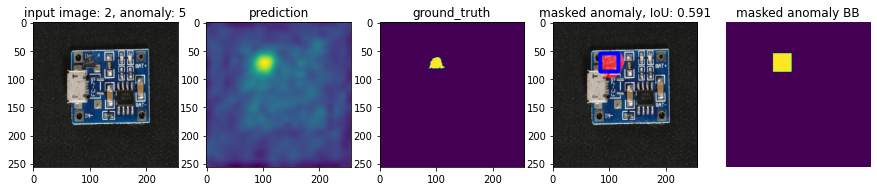

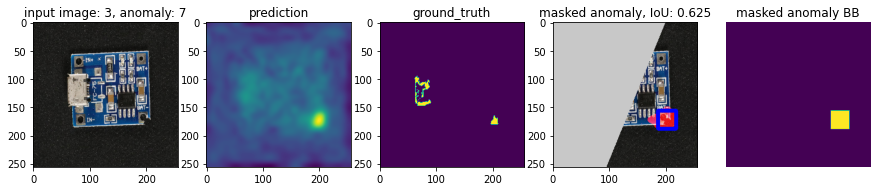

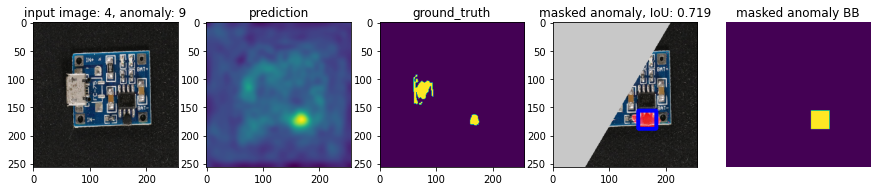

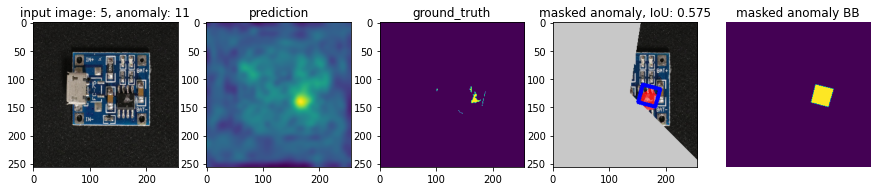

In [25]:
pl.visualise_PL(input_images,
                predictions,
                ground_truths, 
                iou_array,
                thres_value, 
                thres_ind,
                all_prediction_masks, 
                all_anomaly_masks, 
                all_bounding_box_infos,
                specific_indices=np.where(iou_array[thres_ind]>0.5)[0][:5])

Setting to specific_indices to [] (default), will result in all the anomalies plotted.

In [26]:
# pl.visualise_PL(input_images,
#                 predictions,
#                 ground_truths, 
#                 iou_array,
#                 thres_value, 
#                 thres_ind,
#                 all_prediction_masks, 
#                 all_anomaly_masks, 
#                 all_bounding_box_infos,
#                 )

If you wish to plot the results yourself, you have access to:
- input_images (single list)
- predictions (single list)
- ground_truths (single list)
- iou_array (2d array)
- thres_value (float)
- thres_ind (int)
- all_prediction_masks (list of lists)
- all_anomaly_masks (list of lists)
- all_bounding_box_infos (list of lists)

Note the last three items are lists of lists, where the outer lists corresponds to each input image/prediction, whilst each internal list corresponds to the prediction masks, anomaly masks, and bounding box paramteres for each anomaly of that image, e.g.
The external list indices correspond to the input_images/predictions/ground_truths
To make these item of the internal lists align with the iou array, you would need to flatten the lists of lists. 

- (image_0)
    - image_0_anomaly_0
    - image_0_anomaly_2
    - image_0_anomaly_3
- (image_1)
    - image_1_anomaly_0
    - image_1_anomaly_1
- (image_2)
    - image_2_anomaly_0
    
See below for a demo of looping through the above lists to access all info per anomaly

In [27]:
ii = -1
ious = iou_array[thres_ind]
for image_ind, (prediction, 
                input_image, 
                ground_truth, 
                prediction_masks, 
                anomaly_masks, 
                bb_infos) in enumerate(zip(predictions, 
                                           input_images,
                                           ground_truths, 
                                           all_prediction_masks, 
                                           all_anomaly_masks, 
                                           all_bounding_box_infos)):


    for prediction_mask, anomaly_mask, bb_info in zip(prediction_masks, anomaly_masks, bb_infos):
        ii+=1

        # use IoU from the array
        iou = ious[ii]

        nov_threshold = prediction>thres_value
        
        # or calculate IoU
        IoU = pl.calculate_IoU(predictions=np.logical_and(nov_threshold, prediction_mask), mask=anomaly_mask)

        print("input_image.shape: ", input_image.shape)
        print("prediction.shape: ", prediction.shape)
        print("ground_truth.shape: ", ground_truth.shape)
        print("prediction_mask.shape: ", prediction_mask.shape)
        print("anomaly_mask.shape: ", anomaly_mask.shape)
        print("Bounding box info: ", bb_info)
        print("")

    if image_ind>2:
        break

input_image.shape:  torch.Size([3, 256, 256])
prediction.shape:  torch.Size([256, 256])
ground_truth.shape:  torch.Size([256, 256])
prediction_mask.shape:  (256, 256)
anomaly_mask.shape:  (256, 256)
Bounding box info:  ((192.75001525878906, 100.25000762939453), (32.0, 32.0), 18.434947967529297)

input_image.shape:  torch.Size([3, 256, 256])
prediction.shape:  torch.Size([256, 256])
ground_truth.shape:  torch.Size([256, 256])
prediction_mask.shape:  (256, 256)
anomaly_mask.shape:  (256, 256)
Bounding box info:  ((72.5, 121.0), (33.0, 52.0), 0.0)

input_image.shape:  torch.Size([3, 256, 256])
prediction.shape:  torch.Size([256, 256])
ground_truth.shape:  torch.Size([256, 256])
prediction_mask.shape:  (256, 256)
anomaly_mask.shape:  (256, 256)
Bounding box info:  ((163.0, 101.0), (32.0, 32.0), 0.0)

input_image.shape:  torch.Size([3, 256, 256])
prediction.shape:  torch.Size([256, 256])
ground_truth.shape:  torch.Size([256, 256])
prediction_mask.shape:  (256, 256)
anomaly_mask.shape:  (256

(-0.5, 255.5, 255.5, -0.5)

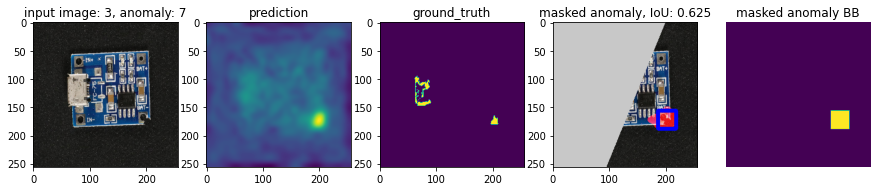

In [28]:
im = pl.make_demo_image(input_image,
                        (prediction>thres_value).numpy(), 
                        prediction_mask, 
                        bb_info)

fig, axes = plt.subplots(1, 5, figsize=(15, 75))

axes[0].imshow(pl.tensor_to_cv2(input_image))
axes[1].imshow(prediction)
axes[2].imshow(ground_truth)
axes[3].imshow(im)
axes[4].imshow(anomaly_mask)

axes[0].set_title(f"input image: {image_ind}, anomaly: {ii}")
axes[1].set_title("prediction")
axes[2].set_title("ground_truth")
axes[3].set_title(f"masked anomaly, IoU: {ious[ii]:.3g}")
axes[4].set_title(f"masked anomaly BB")

plt.axis('off')

The code for make_demo_image is shown below to help get you started creating your own demo images.

In [29]:
# def make_demo_image(input_image, h_map_w_threshold, prediction_mask, bb_info):
#     '''
#     Takes the input image, the heatmap with threshold applied, the prediction mask,
#     and the bounding box info of the target
#     returns an image with the mask applied to the input image, the thresheld heatmap
#     drawn on the image as a red tint, and the rotated bounding box drawn in blue
#     '''
#     im = tensor_to_cv2(input_image)
#     im = im*prediction_mask[:,:,None].astype(np.uint8)
#     gray_out = im==0
    
#     mask_bgr = cv2.merge([h_map_w_threshold.astype(np.uint8), 
#                           h_map_w_threshold.astype(np.uint8), 
#                           h_map_w_threshold.astype(np.uint8)])
    
#     alpha = 0.9  # Adjust as needed

#     red_shade = np.zeros_like(mask_bgr, dtype=np.uint8)
#     red_shade[:, :, 0] = 255  # Set the red channel to 255
#     red_shade[mask_bgr==0] = 0
    
#     im[:,:,0][mask_bgr[:,:,0]>0] = im[:,:,0][mask_bgr[:,:,0]>0]*(1-alpha)

#     im = cv2.addWeighted(im, 1, red_shade, alpha, 0,)
    
#     im[gray_out] = 200
    
#     drawcontour(im, bb_info)
    
#     return im